## Task :

The goal of the project is to develop a model that can predict the age of an abalone based purely on the other physical measurements.
The age of an abalone can be found by cutting its shell and counting the number of rings on the shell.
This would allow researchers to estimate the abalone’s age without having to cut its shell and count the rings.

We’ll be applying a kNN to find the closest prediction score possible.

In the [Abalone Dataset](https://archive.ics.uci.edu/dataset/1/abalone), we have the age measurements of a large number of abalones along with a lot of other physical measurements.

## Exploratory Data Analysis

### Importing the Abalone Dataset :

In this code, we'll first import pandas, then use it to read the data. We specify the path to be a URL so the file will be fetched directly over the Internet.

In [1]:
import pandas as pd
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases"
    "/abalone/abalone.data"
)
abalone = pd.read_csv(url, header=None)



To make sure that we’ve imported the data correctly, you can do a quick check as follows:

In [14]:
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


This should show us the first five lines of the Abalone Dataset, imported in Python as a pandas DataFrame. We can see that the column names are still missing. We can find those names in the [abalone.names](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone) file on the UCI machine learning repository.

We can find those names in the abalone.names file on the UCI machine learning repository. We are going to add them to our DataFrame as follows:

In [2]:
abalone.columns = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Shucked weight",
    "Viscera weight",
    "Shell weight",
    "Rings",
]

Since sex is not a purely physical measure, We should remove it.

In [3]:
abalone = abalone.drop("Sex", axis=1)

### Data Distribution      

The target variable of this exercise is `Rings`, so we can start with that. A histogram will give us a quick and useful overview of the age ranges that we can expect:

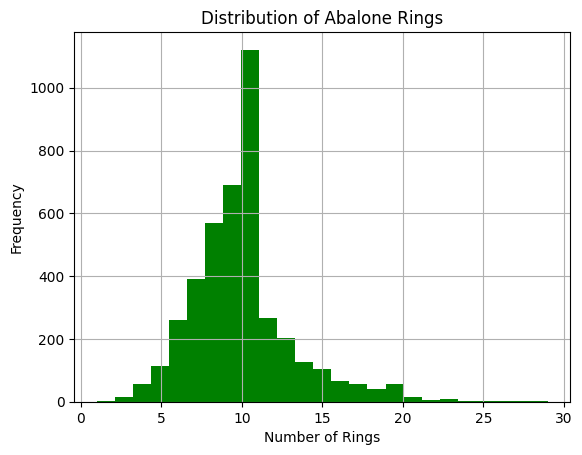

In [4]:
import matplotlib.pyplot as plt

abalone["Rings"].hist(bins=25, color='green')
# Add labels to the x-axis and y-axis
plt.xlabel("Number of Rings")
plt.ylabel("Frequency")
plt.title("Distribution of Abalone Rings")

plt.show()

#### Interpretation

- This code uses the pandas plotting functionality to generate a histogram with withe specified number of bins. When defining the number of bins, you generally try to have neither too many observations per bin nor too few. Too few bins can hide certain patterns, while too many bins can make the histogram lack smoothness.

- The histogram shows that most abalones in the dataset have between five and fifteen rings, but that it’s possible to get up to twenty-five rings. The older abalones are underrepresented in this dataset. This seems intuitive, as age distributions are generally skewed like this due to natural processes.

### Correlation

A second relevant exploration is to find out which of the variables, if any, have a strong correlation with the age. A strong correlation between an independent variable and your goal variable would be a good sign, as this would confirm that physical measurements and age are related.

You can observe the complete correlation matrix in correlation_matrix. The most important correlations are the ones with the target variable Rings. You can get those correlations like this:

In [5]:
correlation_matrix = abalone.corr()
correlation_matrix["Rings"]

Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
Rings             1.000000
Name: Rings, dtype: float64

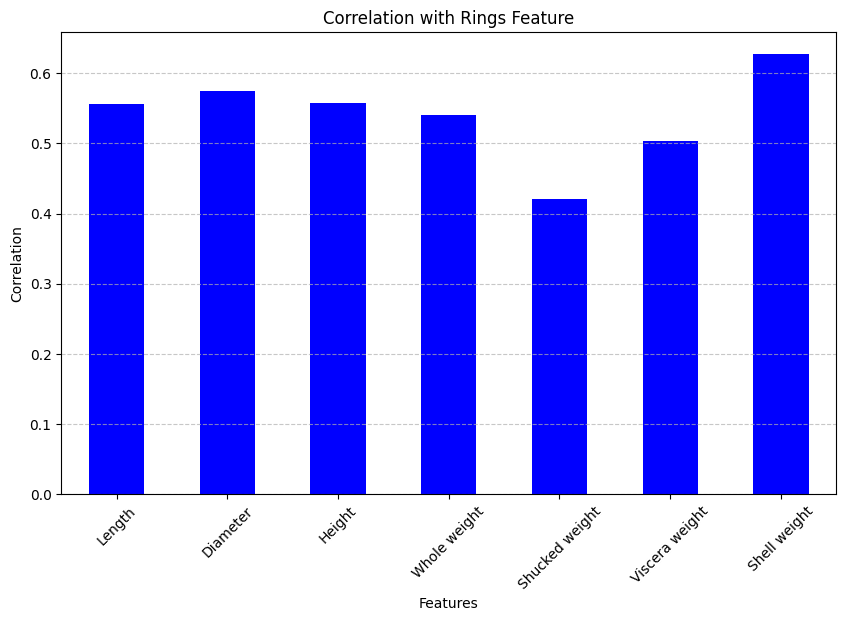

In [6]:
import matplotlib.pyplot as plt

# Assuming correlation_matrix["Rings"] contains the correlations we've provided
correlation_matrix["Rings"].drop("Rings").plot(kind="bar", color='blue', figsize=(10, 6))
plt.title("Correlation with Rings Feature")
plt.xlabel("Features")
plt.ylabel("Correlation")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


#### Interpretation :
We can conclude that there’s at least some correlation between physical measurements of adult abalones and their age, yet it’s also not very high. Very high correlations mean that we can expect a straightforward modeling process. In this case, we’ll have to try and see what results we can obtain using the kNN algorithm.

## Model building

### Model overview

In this part of the tutorial, you’re going to discover how the kNN algorithm works deep down. The algorithm has two main mathematical components that you’ll need to understand.

Each machine learning model has its specific formula that needs to be estimated. But what makes k-Nearest Neighbors algorithm different from other ML models  is that this formula is computed not at the moment of fitting but rather at the moment of prediction.

When a new data point arrives, the kNN algorithm, as the name indicates, will start by finding the nearest neighbors of this new data point. Then it takes the values of those neighbors and uses them as a prediction for the new data point.

### Finding the Nearest Neighbors

To find the closest data points to the one you need to predict, we use Euclidean distance, a mathematical measure of distance. Euclidean distance is based on the difference between vectors, which represent points in space. For example, if you have two points at (2,2) and (4,4), you can find the distance between them by subtracting their coordinates to get a difference vector. The length of this vector, called the norm, is the distance between the points. The Euclidean formula calculates distance by summing the squared differences of each dimension and then taking the square root of the total. This applies to data points treated as vectors. By computing the norm of the difference vectors between data points, you can find their distances.

### Splitting the data :

Before diving into that, we need to perform a quick step, which is seperating our target variable `Rings`. So let's generates two objects that now contain our data points (vectors) X and y contain our target variable `Rings`.
X is the independent variables and y is the dependent variable of your model.

In [7]:
X = abalone.drop("Rings", axis=1)
X = X.values
y = abalone["Rings"]
y = y.values

### Computing the Euclidian Distance

The next step is to compute the distances between a new data point that we want to predict and each of the data points in the Abalone Dataset using the following code:

In [8]:
import numpy as np
new_data_point = np.array([
     0.569552,
     0.446407,
     0.154437,
     1.016849,
     0.439051,
     0.222526,
     0.291208,
 ])

In [9]:
distances = np.linalg.norm(X - new_data_point, axis=1)

Now, we have a vector of distances, and we need to find out which are the three closest neighbors. To do this, we need to find the IDs of the minimum distances. We can use a method called.argsort() to sort the array from lowest to highest, and we can take the first k elements to obtain the indices of the k nearest neighbors:

In [10]:
k = 3
nearest_neighbor_ids = distances.argsort()[:k]
nearest_neighbor_ids


array([4045, 1902, 1644])

This tells us which three neighbors are closest to our new_data_point. In the next paragraph, we’ll see how to convert those neighbors in an estimation.

### Prediction

Having identified the indices of the three nearest neighbors of our abalone of unknown age, we now need to combine those neighbors into a prediction for our new data point.

As a first step, we need to find the ground truths for those three neighbors:

In [11]:
nearest_neighbor_rings = y[nearest_neighbor_ids]
nearest_neighbor_rings

array([ 9, 11, 10])

Now that you have the values for those three neighbors, we’ll combine them into a prediction for your new data point. Combining the neighbors into a prediction works differently for regression and classification.

#### Average for Regression

In regression problems, the target variable is numeric. We combine multiple neighbors into one prediction by taking the average of their values of the target variable. We can do this as follows:

In [12]:
prediction = nearest_neighbor_rings.mean()

We’ll get a value of 10 for prediction. This means that the 3-Nearest Neighbor prediction for our new data point is 10. We could do the same for any number of new abalones that We want.

#### Mode for Classification

In classification problems, the target variable is categorical, making it impossible to take averages like in numerical variables. For instance, we can't find the average of predicted car brands. Instead, classification uses the mode, which is the most frequent value. This means counting the classes of neighboring points and selecting the most common class as the prediction. If there are multiple modes, various solutions are possible, such as randomly selecting a winner or considering distances of neighbors. The SciPy `mode()` function can compute the mode, although in the provided example, it's not used for classification but for a toy example.:

In [13]:
import scipy
class_neighbors = np.array([1,2,2])
scipy.stats.mode(class_neighbors)
# mode, count = np.unique(class_neighbors, return_counts=True)
# mode = mode[count.argmax()]

# print("Mode:", mode)


ModeResult(mode=2, count=2)

## Testing our model performance

In [29]:
np.random.randint(0, X.shape[0], size=10)

array([2092, 2536, 1089, 3703, 3314,  828, 3998, 3790, 2202,  209])

In [17]:
np.random.randint(0, X.shape[0], size=1)

array([3520])

In [18]:
X

array([[0.455 , 0.365 , 0.095 , ..., 0.2245, 0.101 , 0.15  ],
       [0.35  , 0.265 , 0.09  , ..., 0.0995, 0.0485, 0.07  ],
       [0.53  , 0.42  , 0.135 , ..., 0.2565, 0.1415, 0.21  ],
       ...,
       [0.6   , 0.475 , 0.205 , ..., 0.5255, 0.2875, 0.308 ],
       [0.625 , 0.485 , 0.15  , ..., 0.531 , 0.261 , 0.296 ],
       [0.71  , 0.555 , 0.195 , ..., 0.9455, 0.3765, 0.495 ]])

In [19]:
X.shape

(4177, 7)

In [21]:
np.delete(X, 1, axis=0)

array([[0.455 , 0.365 , 0.095 , ..., 0.2245, 0.101 , 0.15  ],
       [0.53  , 0.42  , 0.135 , ..., 0.2565, 0.1415, 0.21  ],
       [0.44  , 0.365 , 0.125 , ..., 0.2155, 0.114 , 0.155 ],
       ...,
       [0.6   , 0.475 , 0.205 , ..., 0.5255, 0.2875, 0.308 ],
       [0.625 , 0.485 , 0.15  , ..., 0.531 , 0.261 , 0.296 ],
       [0.71  , 0.555 , 0.195 , ..., 0.9455, 0.3765, 0.495 ]])

In [24]:
X[1]

array([0.35  , 0.265 , 0.09  , 0.2255, 0.0995, 0.0485, 0.07  ])

In [66]:
y_pred = []
Y = []

for idx in np.random.randint(0, X.shape[0], size=100) :


    # Select the array 'a' from X along with its associated element 'b' from y by index
    test_data_point_X = X[idx]
    Y.append(y[idx])

    # Remove the selected array and its associated element from X and y
    test_X = np.delete(X, idx, axis=0)
    test_y = np.delete(y, idx)

    test_distances = np.linalg.norm(test_X - test_data_point_X, axis=1)
    test_nearest_neighbors_ids = test_distances.argsort()[:10]
    test_nearest_neighbors = test_y[test_nearest_neighbors_ids]

    y_pred.append(test_nearest_neighbors.mean())


print(Y)
print(y_pred)



[10, 11, 10, 14, 7, 3, 12, 7, 10, 8, 12, 9, 9, 8, 10, 7, 7, 11, 7, 13, 10, 20, 17, 9, 13, 9, 8, 10, 14, 12, 12, 9, 10, 9, 9, 18, 6, 8, 9, 7, 17, 9, 21, 9, 9, 12, 9, 8, 10, 15, 8, 8, 9, 10, 16, 24, 8, 8, 6, 11, 9, 9, 17, 10, 7, 21, 7, 10, 11, 8, 8, 11, 10, 14, 16, 10, 9, 22, 10, 10, 10, 9, 10, 20, 11, 6, 9, 10, 9, 10, 9, 13, 13, 11, 14, 8, 9, 9, 13, 13]
[9.9, 10.6, 11.4, 8.8, 7.6, 4.6, 13.7, 7.0, 10.2, 7.7, 8.3, 8.1, 12.0, 9.4, 14.5, 7.8, 7.5, 11.8, 9.2, 9.9, 11.5, 16.3, 14.8, 10.5, 13.1, 9.4, 8.4, 9.0, 9.5, 10.3, 14.5, 10.0, 10.9, 10.9, 8.9, 13.3, 7.7, 7.8, 9.5, 7.2, 11.9, 10.1, 10.7, 9.2, 8.2, 9.8, 10.2, 9.7, 11.4, 12.8, 7.5, 7.4, 8.1, 10.5, 11.0, 14.4, 8.0, 9.9, 6.5, 10.2, 10.6, 10.0, 10.9, 9.0, 8.1, 16.7, 9.7, 10.2, 9.9, 10.9, 9.6, 12.7, 9.7, 12.2, 12.3, 11.7, 10.1, 13.7, 8.7, 11.7, 11.4, 10.6, 9.1, 13.4, 9.8, 6.8, 8.0, 7.6, 8.7, 9.8, 10.7, 12.2, 15.7, 15.9, 13.0, 8.0, 8.7, 9.6, 10.4, 8.2]


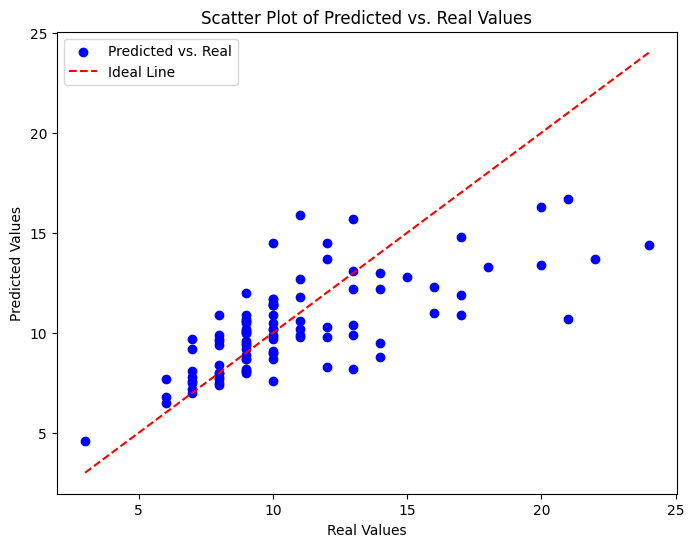

In [67]:
import matplotlib.pyplot as plt

# Plotting the predicted values against the real values
plt.figure(figsize=(8, 6))
plt.scatter(Y, y_pred, color='blue', label='Predicted vs. Real')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color='red', linestyle='--', label='Ideal Line')

# Adding labels and title
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. Real Values')
plt.legend()

# Display the plot
plt.show()


## Final model

Lets, combine all the code built in one class to get a well structured code


In [ ]:
class KNN :

  def __init__(self, k=0):
    self.k = k
    self.nearest_neighbors = []


  def predict_regression(self, X, y, new_data_point):

    distances = np.linalg.norm(X - new_data_point, axis=1)
    nearest_neighbors_ids = distances.argsort()[:self.k]
    self.nearest_neighbors = list(y[nearest_neighbors_ids])

    return self.nearest_neighbors.mean()


  def predict_regression(self, X, y, new_data_point):

    distances = np.linalg.norm(X - new_data_point, axis=1)
    nearest_neighbors_ids = distances.argsort()[:self.k]
    self.nearest_neighbors = list(y[nearest_neighbors_ids])

    return scipy.stats.mode(self.nearest_neighbors)
